<table align="left"><tr><td>
<a href="https://colab.research.google.com/github/rickiepark/nlp-with-transformers/blob/main/08_model-compression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="코랩에서 실행하기"/></a>
</td></tr></table>

In [21]:
# 코랩이나 캐글을 사용한다면 이 셀의 주석을 제거하고 실행하세요.
!git clone https://github.com/rickiepark/nlp-with-transformers.git
%cd nlp-with-transformers
from install import *
install_requirements(chapter=8)

Cloning into 'nlp-with-transformers'...
remote: Enumerating objects: 630, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 630 (delta 32), reused 5 (delta 3), pack-reused 569
Receiving objects: 100% (630/630), 61.46 MiB | 22.56 MiB/s, done.
Resolving deltas: 100% (320/320), done.
/content/nlp-with-transformers/nlp-with-transformers
⏳ Installing base requirements ...
✅ Base requirements installed!
Using transformers v4.34.0
Using datasets v2.14.5
Using accelerate v0.23.0
Using optuna v3.3.0
Using onnxruntime v1.16.1
Using onnx v1.14.1


# 효율적인 트랜스포머 구축

<img alt="Scaling BERT at Roblox" caption="How Roblox scaled BERT with knowledge distillation, dynamic padding, and weight quantization (photo courtesy of Roblox employees Quoc N. Le and Kip Kaehler)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter08_roblox.png?raw=1" id="roblox"/>

## 의도 탐지 예제

<img alt="Out of Scope Query" width="400" caption="Three exchanges between a human (right) and a text-based assistant (left) for personal finance (courtesy of Stefan Larson et al.)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter08_oos.png?raw=1" id="oos"/>

In [22]:
from transformers import pipeline

bert_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=bert_ckpt)

In [23]:
query = """Hey, I'd like to rent a vehicle from Nov 1st to Nov 15th in
Paris and I need a 15 passenger van"""
pipe(query)

[{'label': 'car_rental', 'score': 0.5490034222602844}]

## 벤치마크 클래스 만들기

In [24]:
class PerformanceBenchmark:
    def __init__(self, pipeline, dataset, optim_type="BERT baseline"):
        self.pipeline = pipeline
        self.dataset = dataset
        self.optim_type = optim_type

    def compute_accuracy(self):
        # 나중에 정의합니다
        pass

    def compute_size(self):
        # 나중에 정의합니다
        pass

    def time_pipeline(self):
        # 나중에 정의합니다
        pass

    def run_benchmark(self):
        metrics = {}
        metrics[self.optim_type] = self.compute_size()
        metrics[self.optim_type].update(self.time_pipeline())
        metrics[self.optim_type].update(self.compute_accuracy())
        return metrics

In [25]:
from datasets import load_dataset

clinc = load_dataset("clinc_oos", "plus")

In [26]:
sample = clinc["test"][42]
sample

{'text': 'transfer $100 from my checking to saving account', 'intent': 133}

In [27]:
intents = clinc["test"].features["intent"]
intents.int2str(sample["intent"])

'transfer'

In [28]:
!pip install evaluate

In [29]:
import evaluate

accuracy_score = evaluate.load("accuracy")

In [30]:
def compute_accuracy(self):
    """PerformanceBenchmark.compute_accuracy() 메서드를 오버라이드합니다"""
    preds, labels = [], []
    for example in self.dataset:
        pred = self.pipeline(example["text"])[0]["label"]
        label = example["intent"]
        preds.append(intents.str2int(pred))
        labels.append(label)
    accuracy = accuracy_score.compute(predictions=preds, references=labels)
    print(f"테스트 세트 정확도 - {accuracy['accuracy']:.3f}")
    return accuracy

PerformanceBenchmark.compute_accuracy = compute_accuracy

In [31]:
list(pipe.model.state_dict().items())[42]

('bert.encoder.layer.2.attention.self.value.bias',
 tensor([-2.7834e-02,  4.9434e-02,  8.3551e-02,  4.1092e-02,  6.0157e-01,
          1.1774e-01, -5.2112e-02, -6.5143e-02, -2.9358e-02, -4.2250e-02,
          7.9177e-02,  8.0409e-02,  2.9921e-03,  1.7816e-01, -5.0480e-02,
         -1.5634e-01, -2.1707e-02,  1.4381e-02,  2.5132e-02, -2.4110e-02,
         -1.9183e-01, -7.8657e-02,  5.0709e-02,  3.3632e-02, -3.1946e-02,
          1.1616e-01,  9.2720e-02, -1.1787e-01,  2.3233e-01, -1.2678e-02,
         -1.3138e-01, -4.0024e-02,  7.4823e-02, -5.4148e-02, -1.5184e-01,
         -7.4407e-02,  1.1559e-01,  8.2729e-02, -1.3787e-01,  8.3528e-02,
          1.2154e-01,  1.6880e-02, -5.6629e-02, -3.9295e-02,  5.3725e-02,
          6.8602e-02, -1.1294e-01,  4.4001e-02, -2.5884e-01,  1.6767e-01,
          1.8316e-01,  5.6272e-02, -3.6874e-02, -2.7938e-02, -9.3204e-02,
         -7.5239e-03,  4.1141e-02, -1.1542e-02, -9.9749e-02, -3.0910e-02,
          4.1398e-02, -4.4389e-02, -2.6279e-02,  7.2100e-02, 

In [32]:
import torch
from pathlib import Path

def compute_size(self):
    """PerformanceBenchmark.compute_size() 메서드를 오버라이드합니다"""
    state_dict = self.pipeline.model.state_dict()
    tmp_path = Path("model.pt")
    torch.save(state_dict, tmp_path)
    # 메가바이트 단위로 크기를 계산합니다
    size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
    # 임시 파일을 삭제합니다
    tmp_path.unlink()
    print(f"모델 크기 (MB) - {size_mb:.2f}")
    return {"size_mb": size_mb}

PerformanceBenchmark.compute_size = compute_size

In [33]:
from time import perf_counter

for _ in range(3):
    start_time = perf_counter()
    _ = pipe(query)
    latency = perf_counter() - start_time
    print(f"레이턴시 (ms) - {1000 * latency:.3f}")

레이턴시 (ms) - 50.743
레이턴시 (ms) - 44.682
레이턴시 (ms) - 38.030


In [34]:
import numpy as np

def time_pipeline(self, query="What is the pin number for my account?"):
    """PerformanceBenchmark.time_pipeline() 메서드를 오버라이드합니다d"""
    latencies = []
    # 워밍업
    for _ in range(10):
        _ = self.pipeline(query)
    # 실행 측정
    for _ in range(100):
        start_time = perf_counter()
        _ = self.pipeline(query)
        latency = perf_counter() - start_time
        latencies.append(latency)
    # 통게 계산
    time_avg_ms = 1000 * np.mean(latencies)
    time_std_ms = 1000 * np.std(latencies)
    print(f"평균 레이턴시 (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
    return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}

PerformanceBenchmark.time_pipeline = time_pipeline

In [35]:
pb = PerformanceBenchmark(pipe, clinc["test"])
perf_metrics = pb.run_benchmark()

모델 크기 (MB) - 418.15
평균 레이턴시 (ms) - 28.53 +\- 2.69
테스트 세트 정확도 - 0.867


## 지식 정제로 모델 크기 줄이기

### 미세 튜닝을 위한 지식 정제

<img alt="Soft Probabilities" caption="Comparison of a hard label that is one-hot encoded (left), softmax probabilities (middle), and softened class probabilities (right)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter08_soft-probs.png?raw=1" id="soft-probs"/>

<img alt="Knowledge distillation" caption="The knowledge distillation process" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter08_kd.png?raw=1" id="kd"/>

### 사전 훈련을 위한 지식 정제

### 지식 정제 트레이너 만들기

In [36]:
from transformers import TrainingArguments

class DistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.temperature = temperature

In [37]:
import torch.nn as nn
import torch.nn.functional as F
from transformers import Trainer

class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model

    def compute_loss(self, model, inputs, return_outputs=False):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        inputs = inputs.to(device)
        outputs_stu = model(**inputs)
        # 스튜던트의 크로스 엔트로피 손실과 로짓을 추출합니다
        loss_ce = outputs_stu.loss
        logits_stu = outputs_stu.logits
        # 티처의 로짓을 추출합니다
        with torch.no_grad():
            outputs_tea = self.teacher_model(**inputs)
            logits_tea = outputs_tea.logits
        # 확률을 부드럽게하고 정제 손실을 계산합니다
        loss_fct = nn.KLDivLoss(reduction="batchmean")
        loss_kd = self.args.temperature ** 2 * loss_fct(
            F.log_softmax(logits_stu / self.args.temperature, dim=-1),
            F.softmax(logits_tea / self.args.temperature, dim=-1))
        # 가중 평균된 스튜던트 손실을 반환합니다
        loss = self.args.alpha * loss_ce + (1. - self.args.alpha) * loss_kd
        return (loss, outputs_stu) if return_outputs else loss

### 좋은 스튜던트 초기화 선택하기

In [38]:
from transformers import AutoTokenizer

student_ckpt = "distilbert-base-uncased"
student_tokenizer = AutoTokenizer.from_pretrained(student_ckpt)

def tokenize_text(batch):
    return student_tokenizer(batch["text"], truncation=True)

clinc_enc = clinc.map(tokenize_text, batched=True, remove_columns=["text"])
clinc_enc = clinc_enc.rename_column("intent", "labels")

Map:   0%|          | 0/3100 [00:00<?, ? examples/s]

In [39]:
from huggingface_hub import notebook_login

notebook_login()

In [40]:
def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy_score.compute(predictions=predictions, references=labels)

In [41]:
batch_size = 48

finetuned_ckpt = "distilbert-base-uncased-finetuned-clinc"
student_training_args = DistillationTrainingArguments(
    output_dir=finetuned_ckpt, evaluation_strategy = "epoch",
    num_train_epochs=5, learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size, alpha=1, weight_decay=0.01,
    push_to_hub=True)

In [42]:
student_training_args.logging_steps = len(clinc_enc['train']) // batch_size
student_training_args.disable_tqdm = False
student_training_args.save_steps = 1e9
# 트랜스포머 4.23.0 버전부터 로깅 수준을 문자열로 지정해야 합니다.
# student_training_args.log_level = 40
student_training_args.log_level = 'error'

In [43]:
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


In [44]:
id2label = pipe.model.config.id2label
label2id = pipe.model.config.label2id

In [45]:
from transformers import AutoConfig

num_labels = intents.num_classes
student_config = (AutoConfig
                  .from_pretrained(student_ckpt, num_labels=num_labels,
                                   id2label=id2label, label2id=label2id))

In [46]:
import torch
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def student_init():
    return (AutoModelForSequenceClassification
            .from_pretrained(student_ckpt, config=student_config).to(device))

In [47]:
teacher_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
teacher_model = (AutoModelForSequenceClassification
                 .from_pretrained(teacher_ckpt, num_labels=num_labels)
                 .to(device))

In [48]:
distilbert_trainer = DistillationTrainer(model_init=student_init,
    teacher_model=teacher_model, args=student_training_args,
    train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'],
    compute_metrics=compute_metrics, tokenizer=student_tokenizer)

distilbert_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,4.296700,3.281034,0.718065
2,2.614600,1.865238,0.840323
3,1.537800,1.147739,0.897742
4,1.004300,0.849075,0.913548
5,0.790200,0.768114,0.918387


TrainOutput(global_step=1590, training_loss=2.044702070614077, metrics={'train_runtime': 100.2284, 'train_samples_per_second': 760.762, 'train_steps_per_second': 15.864, 'total_flos': 413013830824140.0, 'train_loss': 2.044702070614077, 'epoch': 5.0})

In [49]:
distilbert_trainer.push_to_hub("Training completed!")

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/4.16k [00:00<?, ?B/s]

'https://huggingface.co/haesun/distilbert-base-uncased-finetuned-clinc/tree/main/'

In [50]:
# `haesun`를 자신의 허브 사용자 이름으로 바꾸세요.
finetuned_ckpt = "haesun/distilbert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=finetuned_ckpt)

In [51]:
optim_type = "DistilBERT"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

모델 크기 (MB) - 255.88
평균 레이턴시 (ms) - 14.44 +\- 0.90
테스트 세트 정확도 - 0.856


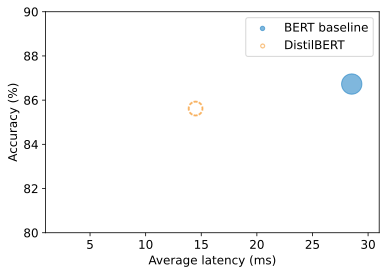

In [52]:
import pandas as pd

def plot_metrics(perf_metrics, current_optim_type):
    df = pd.DataFrame.from_dict(perf_metrics, orient='index')

    for idx in df.index:
        df_opt = df.loc[idx]
        # 현재 최적화 방법을 점선으로 그립니다
        if idx == current_optim_type:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
                        alpha=0.5, s=df_opt["size_mb"], label=idx,
                        marker='$\u25CC$')
        else:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
                        s=df_opt["size_mb"], label=idx, alpha=0.5)

    legend = plt.legend(bbox_to_anchor=(1,1))
    for handle in legend.legend_handles:
        handle.set_sizes([20])

    plt.ylim(80,90)
    # 가장 느린 모델을 사용해 x 축 범위를 정합니다
    xlim = int(perf_metrics["BERT baseline"]["time_avg_ms"] + 3)
    plt.xlim(1, xlim)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Average latency (ms)")
    plt.show()

plot_metrics(perf_metrics, optim_type)

### 옵투나로 좋은 하이퍼파라미터 찾기

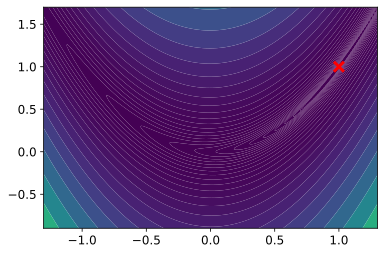

In [53]:
# 두 변수를 가진 로젠브록 함수 그래프
import matplotlib.pyplot as plt
import numpy as np

def f(x, y):
    return (1-x)**2+100*(y-x**2)**2

X, Y = np.meshgrid(np.linspace(-2, 2, 250), np.linspace(-1, 3, 250))
Z = f(X,Y)
_, ax = plt.subplots()
ax.plot([1], [1], 'x', mew=3, markersize=10, color="red")
ax.contourf(X, Y, Z, np.logspace(-1, 3, 30), cmap='viridis', extend="both")
ax.set_xlim(-1.3, 1.3)
ax.set_ylim(-0.9, 1.7)
plt.show()

In [54]:
def objective(trial):
    x = trial.suggest_float("x", -2, 2)
    y = trial.suggest_float("y", -2, 2)
    return (1 - x) ** 2 + 100 * (y - x ** 2) ** 2

In [55]:
import optuna

study = optuna.create_study()
study.optimize(objective, n_trials=1000)

[I 2023-10-16 15:09:31,072] A new study created in memory with name: no-name-90487839-fbe4-4a58-846d-5198841b9723
[I 2023-10-16 15:09:31,076] Trial 0 finished with value: 2318.8067499999274 and parameters: {'x': -1.7067444012674398, 'y': -1.894809197818271}. Best is trial 0 with value: 2318.8067499999274.
[I 2023-10-16 15:09:31,077] Trial 1 finished with value: 478.3838492558652 and parameters: {'x': -1.5869432061329314, 'y': 0.34654257987493553}. Best is trial 1 with value: 478.3838492558652.
[I 2023-10-16 15:09:31,079] Trial 2 finished with value: 270.05284008989065 and parameters: {'x': -0.6212563290172821, 'y': -1.249352066936416}. Best is trial 2 with value: 270.05284008989065.
[I 2023-10-16 15:09:31,081] Trial 3 finished with value: 2344.41555566674 and parameters: {'x': -1.912385997387013, 'y': -1.1759294568668537}. Best is trial 2 with value: 270.05284008989065.
[I 2023-10-16 15:09:31,082] Trial 4 finished with value: 50.61918583119986 and parameters: {'x': 1.0043927104630157, 

In [56]:
study.best_params

{'x': 1.0884186262922515, 'y': 1.1894112108107937}

In [57]:
def hp_space(trial):
    return {"num_train_epochs": trial.suggest_int("num_train_epochs", 5, 10),
        "alpha": trial.suggest_float("alpha", 0, 1),
        "temperature": trial.suggest_int("temperature", 2, 20)}

In [58]:
best_run = distilbert_trainer.hyperparameter_search(
    n_trials=20, direction="maximize", hp_space=hp_space)

[I 2023-10-16 15:09:49,817] A new study created in memory with name: no-name-653ec508-f8dd-4fc9-8d4a-05793d1be06f


Epoch,Training Loss,Validation Loss,Accuracy
1,0.405400,0.207765,0.598065
2,0.174300,0.101478,0.830000
3,0.108200,0.067670,0.890323
4,0.080900,0.051415,0.905161
5,0.067500,0.043446,0.911935
6,0.059500,0.038714,0.914839
7,0.055000,0.036178,0.915161
8,0.052700,0.035322,0.916774


[I 2023-10-16 15:12:26,767] Trial 0 finished with value: 0.9167741935483871 and parameters: {'num_train_epochs': 8, 'alpha': 0.27837371658415, 'temperature': 10}. Best is trial 0 with value: 0.9167741935483871.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.460900,0.234620,0.626452
2,0.192800,0.106571,0.842903
3,0.113000,0.066514,0.902903
4,0.080700,0.048263,0.910000
5,0.065100,0.039416,0.916774
6,0.055900,0.034300,0.923226
7,0.050400,0.031218,0.923226
8,0.046800,0.029184,0.926452
9,0.044700,0.028009,0.926774
10,0.043500,0.027618,0.927097


[I 2023-10-16 15:15:42,698] Trial 1 finished with value: 0.9270967741935484 and parameters: {'num_train_epochs': 10, 'alpha': 0.08369060206775492, 'temperature': 5}. Best is trial 1 with value: 0.9270967741935484.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.385500,0.198615,0.577419
2,0.167900,0.099860,0.824516
3,0.106600,0.068559,0.882903
4,0.081600,0.053483,0.901290
5,0.069400,0.046404,0.905806
6,0.062500,0.042469,0.910968
7,0.059300,0.041107,0.911613


[I 2023-10-16 15:17:59,900] Trial 2 finished with value: 0.9116129032258065 and parameters: {'num_train_epochs': 7, 'alpha': 0.027970789212800717, 'temperature': 19}. Best is trial 1 with value: 0.9270967741935484.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.398700,0.205563,0.586129
2,0.173400,0.102391,0.825806
3,0.109300,0.069644,0.886452
4,0.083200,0.054021,0.901290
5,0.070500,0.046663,0.906774
6,0.063400,0.042627,0.911290
7,0.060000,0.041228,0.911935


[I 2023-10-16 15:20:16,982] Trial 3 finished with value: 0.9119354838709678 and parameters: {'num_train_epochs': 7, 'alpha': 0.7971498400419224, 'temperature': 12}. Best is trial 1 with value: 0.9270967741935484.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.461400,0.235827,0.622903
2,0.194300,0.108265,0.839677
3,0.114800,0.068133,0.900000
4,0.082700,0.049829,0.908710
5,0.067200,0.041047,0.916452
6,0.058100,0.035901,0.920000
7,0.052800,0.033046,0.920645
8,0.049500,0.031301,0.921935
9,0.048000,0.030622,0.925161


[I 2023-10-16 15:23:13,073] Trial 4 finished with value: 0.9251612903225807 and parameters: {'num_train_epochs': 9, 'alpha': 0.7117650469361755, 'temperature': 5}. Best is trial 1 with value: 0.9270967741935484.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.394000,0.207538,0.565806


[I 2023-10-16 15:23:33,354] Trial 5 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy
1,0.392400,0.204036,0.575806


[I 2023-10-16 15:23:53,678] Trial 6 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy
1,0.426700,0.217860,0.614194
2,0.181200,0.103210,0.839677
3,0.109800,0.066931,0.896452
4,0.080500,0.049730,0.907742
5,0.066000,0.041244,0.915161
6,0.057300,0.036177,0.919355
7,0.052200,0.033321,0.919032
8,0.049000,0.031529,0.922258
9,0.047500,0.030859,0.922258


[I 2023-10-16 15:26:49,771] Trial 7 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy
1,0.384800,0.196959,0.580000


[I 2023-10-16 15:27:10,085] Trial 8 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy
1,0.426700,0.217860,0.614194
2,0.181200,0.103210,0.839677
3,0.109800,0.066931,0.896452
4,0.080500,0.049730,0.907742
5,0.066000,0.041244,0.915161
6,0.057300,0.036177,0.919355
7,0.052200,0.033321,0.919032
8,0.049000,0.031529,0.922258
9,0.047500,0.030859,0.922258


[I 2023-10-16 15:30:05,705] Trial 9 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy
1,0.801900,0.408625,0.675161
2,0.308500,0.141427,0.839032
3,0.142000,0.071724,0.902903
4,0.089900,0.050992,0.918710
5,0.070000,0.042506,0.924194
6,0.060100,0.037643,0.929355
7,0.054100,0.034903,0.927742
8,0.050400,0.033142,0.929355
9,0.048300,0.031903,0.929355
10,0.047000,0.031673,0.929355


[I 2023-10-16 15:33:21,343] Trial 10 finished with value: 0.9293548387096774 and parameters: {'num_train_epochs': 10, 'alpha': 0.01626185622974391, 'temperature': 2}. Best is trial 10 with value: 0.9293548387096774.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.801900,0.408625,0.675161
2,0.308500,0.141427,0.839032
3,0.142000,0.071724,0.902903
4,0.089900,0.050992,0.918710
5,0.070000,0.042506,0.924194
6,0.060100,0.037643,0.929355
7,0.054100,0.034903,0.927742
8,0.050400,0.033142,0.929355
9,0.048300,0.031903,0.929355
10,0.047000,0.031673,0.929355


[I 2023-10-16 15:36:37,351] Trial 11 finished with value: 0.9293548387096774 and parameters: {'num_train_epochs': 10, 'alpha': 0.0015781344267938348, 'temperature': 2}. Best is trial 10 with value: 0.9293548387096774.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.801900,0.408625,0.675161
2,0.308500,0.141427,0.839032
3,0.142000,0.071724,0.902903
4,0.089900,0.050992,0.918710
5,0.070000,0.042506,0.924194
6,0.060100,0.037643,0.929355
7,0.054100,0.034903,0.927742
8,0.050400,0.033142,0.929355
9,0.048300,0.031903,0.929355
10,0.047000,0.031673,0.929355


[I 2023-10-16 15:39:53,205] Trial 12 finished with value: 0.9293548387096774 and parameters: {'num_train_epochs': 10, 'alpha': 0.0009642810519617673, 'temperature': 2}. Best is trial 10 with value: 0.9293548387096774.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.801900,0.408625,0.675161
2,0.308500,0.141427,0.839032
3,0.142000,0.071724,0.902903
4,0.089900,0.050992,0.918710
5,0.070000,0.042506,0.924194
6,0.060100,0.037643,0.929355
7,0.054100,0.034903,0.927742
8,0.050400,0.033142,0.929355
9,0.048300,0.031903,0.929355
10,0.047000,0.031673,0.929355


[I 2023-10-16 15:43:09,074] Trial 13 finished with value: 0.9293548387096774 and parameters: {'num_train_epochs': 10, 'alpha': 0.28288721866865, 'temperature': 2}. Best is trial 10 with value: 0.9293548387096774.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.497100,0.253080,0.640645
2,0.205800,0.111015,0.843871
3,0.117200,0.067214,0.902581


[I 2023-10-16 15:44:08,455] Trial 14 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy
1,0.410200,0.209267,0.603871


[I 2023-10-16 15:44:28,721] Trial 15 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy
1,0.804000,0.414439,0.669355
2,0.316500,0.149194,0.833226


[I 2023-10-16 15:45:08,630] Trial 16 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy
1,0.426300,0.216833,0.615484


[I 2023-10-16 15:45:28,957] Trial 17 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy
1,0.394400,0.201020,0.592258


[I 2023-10-16 15:45:49,253] Trial 18 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy
1,0.466200,0.246660,0.607419


[I 2023-10-16 15:46:09,591] Trial 19 pruned. 


In [59]:
print(best_run)

BestRun(run_id='10', objective=0.9293548387096774,
hyperparameters={'num_train_epochs': 10, 'alpha': 0.01626185622974391,
'temperature': 2}, run_summary=None)


In [60]:
for k,v in best_run.hyperparameters.items():
    setattr(student_training_args, k, v)

# 정제된 모델을 저장할 새로운 저장소를 정의합니다
distilled_ckpt = "distilbert-base-uncased-distilled-clinc"
student_training_args.output_dir = distilled_ckpt

# 최적의 매개변수로 새로운 Trainer를 만듭니다
distil_trainer = DistillationTrainer(model_init=student_init,
    teacher_model=teacher_model, args=student_training_args,
    train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'],
    compute_metrics=compute_metrics, tokenizer=student_tokenizer)

distil_trainer.train();

Epoch,Training Loss,Validation Loss,Accuracy
1,0.857600,0.451161,0.679032
2,0.340700,0.165502,0.844194
3,0.161100,0.089016,0.905806
4,0.104600,0.066544,0.920968
5,0.083100,0.057513,0.925484
6,0.072700,0.052300,0.931290
7,0.066400,0.049449,0.928710
8,0.062500,0.047550,0.931290
9,0.060300,0.046273,0.930968
10,0.058900,0.046025,0.931935


In [61]:
distil_trainer.push_to_hub("Training complete")

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.22k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

'https://huggingface.co/haesun/distilbert-base-uncased-distilled-clinc/tree/main/'

### 정제 모델 벤치마크 수행하기

In [62]:
# `haesun`를 자신의 허브 사용자 이름으로 바꾸세요.
distilled_ckpt = "haesun/distilbert-base-uncased-distilled-clinc"
pipe = pipeline("text-classification", model=distilled_ckpt)
optim_type = "Distillation"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

모델 크기 (MB) - 255.88
평균 레이턴시 (ms) - 14.48 +\- 0.86
테스트 세트 정확도 - 0.857


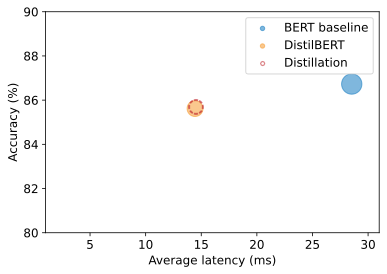

In [63]:
plot_metrics(perf_metrics, optim_type)

## 양자화로 모델 속도 높이기

### 사이드바: 부동 소수점 숫자 vs 고정 소수점 숫자

### End sidebar

<img alt="Mapping floating-point numbers to 8-bit integers" width="800" caption="Quantizing floating-point numbers as unsigned 8-bit integers (courtesy of Manas Sahni)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter08_fp32-to-int8.png?raw=1" id="fp32toint8"/>

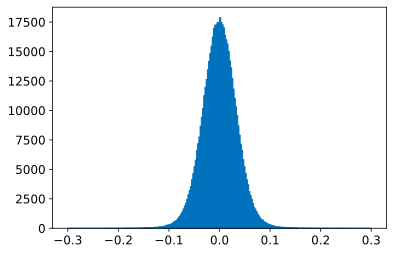

In [64]:
import matplotlib.pyplot as plt

state_dict = pipe.model.state_dict()
weights = state_dict["distilbert.transformer.layer.0.attention.out_lin.weight"]
plt.hist(weights.flatten().numpy(), bins=250, range=(-0.3,0.3), edgecolor="C0")
plt.show()

In [65]:
zero_point = 0
scale = (weights.max() - weights.min()) / (127 - (-128))

In [66]:
(weights / scale + zero_point).clamp(-128, 127).round().char()

tensor([[ -5,  -8,   0,  ...,  -6,  -4,   8],
        [  9,   3,   2,  ...,  -4,   7,   1],
        [ -9,  -6,   5,  ...,   0,   5,  -3],
        ...,
        [  6,   0,  12,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  11,  -8, -13],
        [-13,  -1, -10,  ...,   8,   2,  -1]], dtype=torch.int8)

In [67]:
from torch import quantize_per_tensor

dtype = torch.qint8
quantized_weights = quantize_per_tensor(weights, scale, zero_point, dtype)
quantized_weights.int_repr()

tensor([[ -5,  -8,   0,  ...,  -6,  -4,   8],
        [  9,   3,   2,  ...,  -4,   7,   1],
        [ -9,  -6,   5,  ...,   0,   5,  -3],
        ...,
        [  6,   0,  12,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  11,  -8, -13],
        [-13,  -1, -10,  ...,   8,   2,  -1]], dtype=torch.int8)

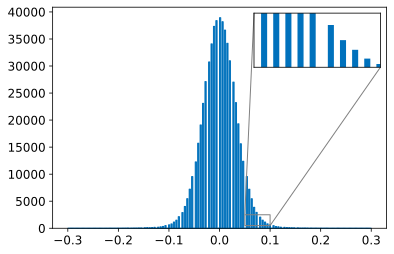

In [68]:
# 트랜스포머 가중치에서 양자화 효과
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes,mark_inset

# 히스토그램 그리기
fig, ax = plt.subplots()
ax.hist(quantized_weights.dequantize().flatten().numpy(),
         bins=250, range=(-0.3,0.3), edgecolor="C0");
# 확대 그림 만들기
axins = zoomed_inset_axes(ax, 5, loc='upper right')
axins.hist(quantized_weights.dequantize().flatten().numpy(),
         bins=250, range=(-0.3,0.3));
x1, x2, y1, y2 = 0.05, 0.1, 500, 2500
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.axes.xaxis.set_visible(False)
axins.axes.yaxis.set_visible(False)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
plt.show()

In [69]:
%%timeit
weights @ weights

3.34 ms ± 124 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [70]:
from torch.nn.quantized import QFunctional

q_fn = QFunctional()

In [71]:
%%timeit
q_fn.mul(quantized_weights, quantized_weights)

231 µs ± 2.51 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [72]:
import sys

sys.getsizeof(weights.untyped_storage()) / sys.getsizeof(quantized_weights.untyped_storage())

3.999715196311114

In [73]:
from torch.quantization import quantize_dynamic

# `haesun`를 자신의 허브 사용자 이름으로 바꾸세요.
model_ckpt = "haesun/distilbert-base-uncased-distilled-clinc"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt).to("cpu"))

model_quantized = quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)

### 양자화된 모델의 벤치마크 수행하기

In [74]:
pipe = pipeline("text-classification", model=model_quantized,
                tokenizer=tokenizer)
optim_type = "Distillation + quantization"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

모델 크기 (MB) - 132.39
평균 레이턴시 (ms) - 12.85 +\- 1.45
테스트 세트 정확도 - 0.861


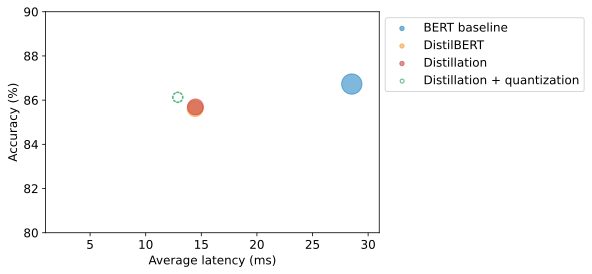

In [75]:
plot_metrics(perf_metrics, optim_type)

## ONNX와 ONNX 런타임으로 추론 최적화하기

<img alt="Example ONNX graph" width="500" caption="A section of the ONNX graph for BERT-base, visualized in Netron" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter08_bert-onnx.png?raw=1" id="bert-onnx"/>

<img alt="Architecture of the ONNX and ONNX Runtime ecosystem" width="500" caption="Architecture of the ONNX and ONNX Runtime ecosystem (courtesy of the ONNX Runtime team)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter08_onnx-ort.png?raw=1" id="onnx-ort"/>

In [76]:
import os
from psutil import cpu_count

os.environ["OMP_NUM_THREADS"] = f"{cpu_count()}"
os.environ["OMP_WAIT_POLICY"] = "ACTIVE"

In [79]:
from transformers.convert_graph_to_onnx import convert

# `haesun`를 자신의 허브 사용자 이름으로 바꾸세요.
model_ckpt = "haesun/distilbert-base-uncased-distilled-clinc"
onnx_model_path = Path("onnx/model.onnx")
convert(framework="pt", model=model_ckpt, tokenizer=tokenizer,
        output=onnx_model_path, opset=12, pipeline_name="text-classification")

/usr/local/lib/python3.10/dist-packages/transformers/convert_graph_to_onnx.py:379: FutureWarning: The `transformers.convert_graph_to_onnx` package is deprecated and will be removed in version 5 of Transformers
  warnings.warn(
Using bos_token, but it is not set yet.
Using eos_token, but it is not set yet.


ONNX opset version set to: 12
Loading pipeline (model: haesun/distilbert-base-uncased-distilled-clinc, tokenizer: DistilBertTokenizerFast(name_or_path='haesun/distilbert-base-uncased-distilled-clinc', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]', 'additional_special_tokens': ['[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]']}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: Adde

/usr/local/lib/python3.10/dist-packages/transformers/models/distilbert/modeling_distilbert.py:223: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  mask, torch.tensor(torch.finfo(scores.dtype).min)


============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [80]:
from onnxruntime import (GraphOptimizationLevel, InferenceSession,
                         SessionOptions)

def create_model_for_provider(model_path, provider="CPUExecutionProvider"):
    options = SessionOptions()
    options.intra_op_num_threads = 1
    options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_ALL
    session = InferenceSession(str(model_path), options, providers=[provider])
    session.disable_fallback()
    return session

In [81]:
onnx_model = create_model_for_provider(onnx_model_path)

In [82]:
inputs = clinc_enc["test"][:1]
del inputs["labels"]
logits_onnx = onnx_model.run(None, inputs)[0]
logits_onnx.shape

(1, 151)

In [83]:
np.argmax(logits_onnx)

61

In [84]:
clinc_enc["test"][0]["labels"]

61

In [85]:
from scipy.special import softmax

class OnnxPipeline:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer

    def __call__(self, query):
        model_inputs = self.tokenizer(query, return_tensors="pt")
        inputs_onnx = {k: v.cpu().detach().numpy()
                       for k, v in model_inputs.items()}
        logits = self.model.run(None, inputs_onnx)[0][0, :]
        probs = softmax(logits)
        pred_idx = np.argmax(probs).item()
        return [{"label": intents.int2str(pred_idx), "score": probs[pred_idx]}]

In [86]:
pipe = OnnxPipeline(onnx_model, tokenizer)
pipe(query)

[{'label': 'car_rental', 'score': 0.57666945}]

In [87]:
class OnnxPerformanceBenchmark(PerformanceBenchmark):
    def __init__(self, *args, model_path, **kwargs):
        super().__init__(*args, **kwargs)
        self.model_path = model_path

    def compute_size(self):
        size_mb = Path(self.model_path).stat().st_size / (1024 * 1024)
        print(f"모델 크기 (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}

In [88]:
optim_type = "Distillation + ORT"
pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type,
                              model_path="onnx/model.onnx")
perf_metrics.update(pb.run_benchmark())

모델 크기 (MB) - 255.98
평균 레이턴시 (ms) - 23.42 +\- 0.58
테스트 세트 정확도 - 0.857


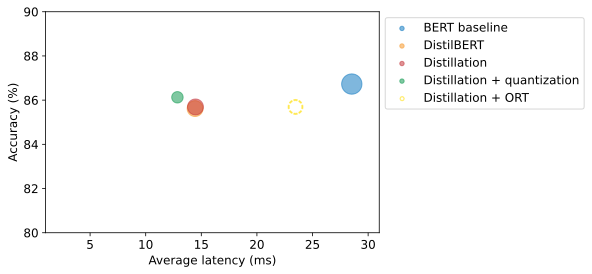

In [89]:
plot_metrics(perf_metrics, optim_type)

In [90]:
from onnxruntime.quantization import quantize_dynamic, QuantType

model_input = "onnx/model.onnx"
model_output = "onnx/model.quant.onnx"
quantize_dynamic(model_input, model_output, weight_type=QuantType.QInt8)

Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.0/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.0/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.1/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.1/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.2/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.2/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.3/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.3/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.4/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.4/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.5/attention/MatMul]
Ignore MatM

In [91]:
onnx_quantized_model = create_model_for_provider(model_output)
pipe = OnnxPipeline(onnx_quantized_model, tokenizer)
optim_type = "Distillation + ORT (quantized)"
pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type,
                              model_path=model_output)
perf_metrics.update(pb.run_benchmark())

모델 크기 (MB) - 64.36
평균 레이턴시 (ms) - 12.60 +\- 0.57
테스트 세트 정확도 - 0.855


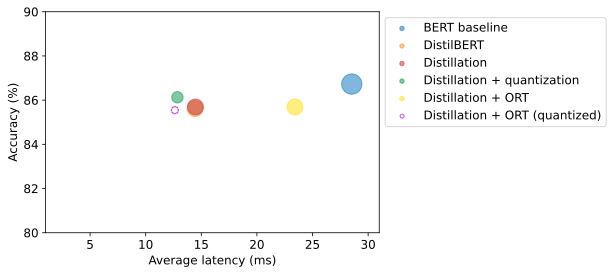

In [92]:
plot_metrics(perf_metrics, optim_type)

## 가중치 가지치기로 희소한 모델 만들기

### 심층 신경망의 희소성

<img alt="Network Pruning" width="500" caption="Weights and neurons before and after pruning (courtesy of Song Han)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter08_network-pruning.png?raw=1" id="network-pruning"/>

### 가중치 가지치기 방법

#### 절댓값 가지치기

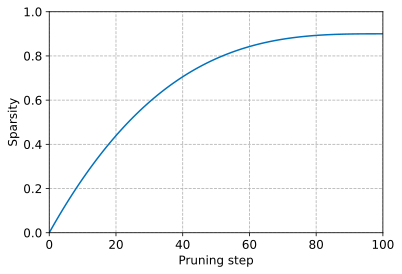

In [93]:
# 가지치기에 사용되는 세제곱 희소성 스케줄러
import numpy as np
import matplotlib.pyplot as plt

def _sparsity(t, t_0=0, dt=1, s_i=0, s_f=0.9, N=100):
    return s_f + (s_i - s_f) * (1 - (t - t_0) / (N * dt))**3

steps = np.linspace(0,100,100)
values = [_sparsity(t) for t in steps]

fig, ax = plt.subplots()
ax.plot(steps, values)
ax.set_ylim(0,1)
ax.set_xlim(0,100)
ax.set_xlabel("Pruning step")
ax.set_ylabel("Sparsity")
plt.grid(linestyle="dashed")
plt.show()

#### 이동 가지치기

<img alt="Magnitude vs Movement Pruning" width="700" caption="Comparison of weights removed (in gray) during magnitude pruning (left) and movement pruning (right)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter08_magnitude-vs-movement.png?raw=1" id="magnitude-vs-movement"/>

<img alt="Pruning Distributions" width="500" caption="Distribution of remaining weights for magnitude pruning (MaP) and movement pruning (MvP)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter08_pruning-dists.png?raw=1" id="pruning-dists"/>

## 결론